# 1. Importing required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import pickle

#**2. Data Generation**

In [2]:
import numpy as np
import pandas as pd

np.random.seed(42)

# Target distribution
total_samples = 500
target_low = 300
target_medium = 125
target_high = 75

data = []
low_count = medium_count = high_count = 0

# Helper function to get thresholds based on machine type
def get_thresholds(machine_type):
    if machine_type == "Conveyor belt":
        return {"oil_quality": range(198, 243), "power_usage":  range(20,201)}
    elif machine_type == "Crusher":
        return {"oil_quality": range(288, 353), "power_usage": range(60,901)}
    elif machine_type == "Loader":
        return {"oil_quality": range(41, 76), "power_usage": range(110,641)}

# Function to determine failure risk
def get_risk(features, thresholds):
    risk = 0
    if features["vibration"] > 5.0: risk += 1
    if features["temperature"] > 50: risk += 1
    if features["load"] > 1.5: risk += 1
    if features["rpm"] > 1500: risk += 1
    if features["sound"] > 90: risk += 1
    if features["downtime_minutes"] > 0.2 * features["planned_operating_time"]: risk += 1
    if features["oil_quality"] not in thresholds["oil_quality"]: risk += 1
    if features["power_usage"] not in thresholds["power_usage"]: risk += 1

    if risk == 0:
        return "Low Risk"
    elif risk <= 2:
        return "Medium Risk"
    else:
        return "High Risk"

# Generate dataset
while low_count < target_low or medium_count < target_medium or high_count < target_high:
    machine_type = np.random.choice(["Conveyor belt", "Crusher", "Loader"])

    # Get machine-specific thresholds
    t = get_thresholds(machine_type)

    # Generate features
    vibration = round(np.random.uniform(0, 10.1), 2)
    temperature = np.random.randint(25, 100)
    load = round(np.random.uniform(0.1, 3.1), 2)
    rpm = np.random.randint(500, 3001)
    sound = np.random.randint(70, 101)

    #for usage_minutes
    if np.random.rand() < 0.8:
        usage_minutes = np.random.randint(60, 961)
    else:
        usage_minutes = np.random.randint(961, 1441)

    planned_operating_time = np.random.choice(list(range(900, 1441, 60)))  # 15–24 hrs

    # for downtime_minutes
    if np.random.rand() < 0.8:
        downtime = np.random.randint(0, int(0.2 * planned_operating_time) + 1)
    else:
        min_dt = int(0.21 * planned_operating_time)
        max_dt = int(0.8 * planned_operating_time)
        downtime = np.random.randint(min_dt, max_dt + 1)

    oil_quality = np.random.randint(0, 301) if machine_type == "Conveyor belt" else\
                  np.random.randint(0, 401) if machine_type == "Crusher" else\
                  np.random.randint(0, 101)
    power_usage = np.random.randint(0, 251) if machine_type == "Conveyor belt" else \
                  np.random.randint(0, 1001) if machine_type == "Crusher" else \
                  np.random.randint(0, 751)

    features = {
        "vibration": vibration,
        "temperature": temperature,
        "load": load,
        "rpm": rpm,
        "sound": sound,
        "usage_minutes": usage_minutes,
        "planned_operating_time": planned_operating_time,
        "downtime_minutes": downtime,
        "oil_quality": oil_quality,
        "power_usage": power_usage
    }

    risk = get_risk(features, t)

    if risk == "Low Risk" and low_count < target_low:
        low_count += 1
    elif risk == "Medium Risk" and medium_count < target_medium:
        medium_count += 1
    elif risk == "High Risk" and high_count < target_high:
        high_count += 1
    else:
        continue

    features["machine_type"] = machine_type
    features["failure_risk"] = risk
    data.append(features)

# Convert to DataFrame
df = pd.DataFrame(data)
print(df["failure_risk"].value_counts())
print(f"Shape: {df.shape}")

failure_risk
Low Risk       300
Medium Risk    125
High Risk       75
Name: count, dtype: int64
Shape: (500, 12)


In [3]:
df.head()

,vibration,temperature,load,rpm,sound,usage_minutes,planned_operating_time,downtime_minutes,oil_quality,power_usage,machine_type,failure_risk
0,8.05,39,2.30,2138,95,390,1320,151,2,661,Loader,High Risk
1,9.80,54,0.74,1715,97,519,1440,235,48,218,Conveyor belt,High Risk
2,4.04,84,1.20,689,99,622,1260,768,2,484,Loader,High Risk
3,6.87,97,0.30,2935,94,1202,1440,52,1,339,Loader,High Risk
4,6.90,68,1.59,534,83,621,1320,53,3,476,Loader,High Risk


#**3. Data Cleaning and Preprocesssing**

In [4]:
#Checking for null values
df.isnull().sum()

,0
vibration,0
temperature,0
load,0
rpm,0
sound,0
usage_minutes,0
planned_operating_time,0
downtime_minutes,0
oil_quality,0
power_usage,0


In [5]:
# Encoding "machine_type" having object values to integer values
le = LabelEncoder()
df['machine_type'] = le.fit_transform(df['machine_type'])

In [6]:
# Calculating downtime_percentage which will be used in calculatig failure risk of machines
df['downtime_percentage'] = ((df['downtime_minutes']/df['planned_operating_time']) * 100).round(2)

In [7]:
df.head()

,vibration,temperature,load,rpm,sound,usage_minutes,planned_operating_time,downtime_minutes,oil_quality,power_usage,machine_type,failure_risk,downtime_percentage
0,8.05,39,2.30,2138,95,390,1320,151,2,661,2,High Risk,11.44
1,9.80,54,0.74,1715,97,519,1440,235,48,218,0,High Risk,16.32
2,4.04,84,1.20,689,99,622,1260,768,2,484,2,High Risk,60.95
3,6.87,97,0.30,2935,94,1202,1440,52,1,339,2,High Risk,3.61
4,6.90,68,1.59,534,83,621,1320,53,3,476,2,High Risk,4.02


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   vibration               500 non-null    float64
 1   temperature             500 non-null    int64  
 2   load                    500 non-null    float64
 3   rpm                     500 non-null    int64  
 4   sound                   500 non-null    int64  
 5   usage_minutes           500 non-null    int64  
 6   planned_operating_time  500 non-null    int64  
 7   downtime_minutes        500 non-null    int64  
 8   oil_quality             500 non-null    int64  
 9   power_usage             500 non-null    int64  
 10  machine_type            500 non-null    int64  
 11  failure_risk            500 non-null    object 
 12  downtime_percentage     500 non-null    float64
dtypes: float64(3), int64(9), object(1)
memory usage: 50.9+ KB


In [9]:
# downloading generated and processed dataset
df.to_csv("machine_failure_dataset.csv", index=False)
from google.colab import files
files.download("machine_failure_dataset.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#**4. Generation of Target features**

In [10]:
# For RUL(Remaining Useful Life) calculation
def calculate_rul(row):
    base_rul = 8640
    penalty = 0

    # Vibration penalty
    if row['vibration'] > 7:
        penalty += 1500
    elif row['vibration'] > 5:
        penalty += 1000

    # Temperature penalty
    if row['temperature'] > 80:
        penalty += 1500
    elif row['temperature'] > 60:
        penalty += 1000
    elif row['temperature'] > 50:
        penalty += 600

    # Load penalty
    if row['load'] > 2.5:
        penalty += 1000
    elif row['load'] > 1.5:
        penalty += 600

    # RPM penalty
    if row['rpm'] > 2500:
        penalty += 1000
    elif row['rpm'] > 2000:
        penalty += 600

    # Sound penalty
    if row['sound'] > 95:
        penalty += 600
    elif row['sound'] > 90:
        penalty += 400

    # Usage penalty (as % of ideal)
    usage_pct = row['usage_minutes'] / 1440
    if usage_pct > 0.9:
        penalty += 800
    elif usage_pct > 0.7:
        penalty += 500

    # Downtime percentage penalty
    if row['downtime_percentage'] > 60:
        penalty += 1200
    elif row['downtime_percentage'] > 40:
        penalty += 800
    elif row['downtime_percentage'] > 20:
        penalty += 500

    # Oil quality penalty based on machine type
    mt = row['machine_type']
    oq = row['oil_quality']
    if (mt == 0 and (oq < 198 or oq > 242)) or \
       (mt == 1 and (oq < 288 or oq > 352)) or \
       (mt == 2 and (oq < 41 or oq > 75)):
        penalty += 800

    # Power usage penalty based on machine type
    pu = row['power_usage']
    if (mt == 0 and (pu < 20 or pu > 200)) or \
       (mt == 1 and (pu < 60 or pu > 900)) or \
       (mt == 2 and (pu < 110 or pu > 640)):
        penalty += 800

    # Final RUL
    rul = base_rul - penalty
    return round(rul, 2)

df["RUL"] = df.apply(calculate_rul, axis=1) # Adding "RUL" column to original dataset

In [11]:
# For assigning failure type for unhealthy machines
def get_failure_type(row):
    reasons = []

    if row['failure_risk'] == "Low Risk":
        return "None"

    if row['vibration'] > 5.0:
        reasons.append("Acoustic Fault")
    if row['temperature'] > 50:
        reasons.append("Overheating")
    if row['load'] > 1.5:
        reasons.append("Overload")
    if row['rpm'] > 1500:
        reasons.append("RPM Overspeed")
    if row['sound'] > 90:
        reasons.append("Acoustic Fault")

    # Oil Quality by machine type
    if (row['machine_type'] == "Conveyor belt" and not (198 <= row['oil_quality'] <= 242)) or \
       (row['machine_type'] == "Crusher" and not (288 <= row['oil_quality'] <= 352)) or \
       (row['machine_type'] == "Loader" and not (41 <= row['oil_quality'] <= 75)):
        reasons.append("Lubrication Issue")

    # Power Usage by machine type
    if (row['machine_type'] == "Conveyor belt" and not (20 <= row['power_usage'] <= 200)) or \
       (row['machine_type'] == "Crusher" and not (60 <= row['power_usage'] <= 900)) or \
       (row['machine_type'] == "Loader" and not (110 <= row['power_usage'] <= 640)):
        reasons.append("Electrical Fault")

    if row['downtime_percentage'] > 20:
        reasons.append("Excess Downtime")

    return ", ".join(sorted(set(reasons))) if reasons else "Unknown"


# Apply to DataFrame
df["failure_type"] = df.apply(get_failure_type, axis=1)

In [12]:
df.head()

,vibration,temperature,load,rpm,sound,usage_minutes,planned_operating_time,downtime_minutes,oil_quality,power_usage,machine_type,failure_risk,downtime_percentage,RUL,failure_type
0,8.05,39,2.30,2138,95,390,1320,151,2,661,2,High Risk,11.44,3940,"Acoustic Fault, Overload, RPM Overspeed"
1,9.80,54,0.74,1715,97,519,1440,235,48,218,0,High Risk,16.32,4340,"Acoustic Fault, Overheating, RPM Overspeed"
2,4.04,84,1.20,689,99,622,1260,768,2,484,2,High Risk,60.95,4540,"Acoustic Fault, Excess Downtime, Overheating"
3,6.87,97,0.30,2935,94,1202,1440,52,1,339,2,High Risk,3.61,3440,"Acoustic Fault, Overheating, RPM Overspeed"
4,6.90,68,1.59,534,83,621,1320,53,3,476,2,High Risk,4.02,5240,"Acoustic Fault, Overheating, Overload"


#**5. Feature Selection and Scaling**

In [13]:
#Input features
X = df.drop(columns = ["failure_risk", "RUL", "failure_type"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Target features
Y_risk = df['failure_risk']
Y_rul = df['RUL']
Y_type = df['failure_type']

#**6. Model Training and Prediction**

In [14]:
# For Failure Risk Classification
X_train_r, X_test_r, Y_train_r, Y_test_r = train_test_split(X_scaled, Y_risk, stratify=Y_risk, test_size=0.2, random_state=42 )
# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_resampled, Y_resampled = smote.fit_resample(X_train_r, Y_train_r)

clf_risk = RandomForestClassifier(class_weight="balanced")
clf_risk.fit(X_resampled,Y_resampled)
Y_pred_r = clf_risk.predict(X_test_r)

In [15]:
# For Remaining Useful Life (RUL) Regression
X_train_u, X_test_u, Y_train_u, Y_test_u = train_test_split(X_scaled, Y_rul, test_size=0.2, random_state=42 )
clf_rul = RandomForestRegressor(random_state=42)
clf_rul.fit(X_train_u, Y_train_u)
Y_pred_u = clf_rul.predict(X_test_u)

In [16]:
# For Failure Type Classification
X_train_y, X_test_y, Y_train_y, Y_test_y = train_test_split(X_scaled, Y_type, test_size=0.2, random_state=42 )
clf_type = RandomForestClassifier(random_state=42)
clf_type.fit(X_train_y, Y_train_y)
Y_pred_y = clf_type.predict(X_test_y)

#**7. Model Evaluation**

Classification Report for Failure Risk:
              precision    recall  f1-score   support

   High Risk       0.82      0.93      0.88        15
    Low Risk       0.97      1.00      0.98        60
 Medium Risk       0.95      0.80      0.87        25

    accuracy                           0.94       100
   macro avg       0.91      0.91      0.91       100
weighted avg       0.94      0.94      0.94       100



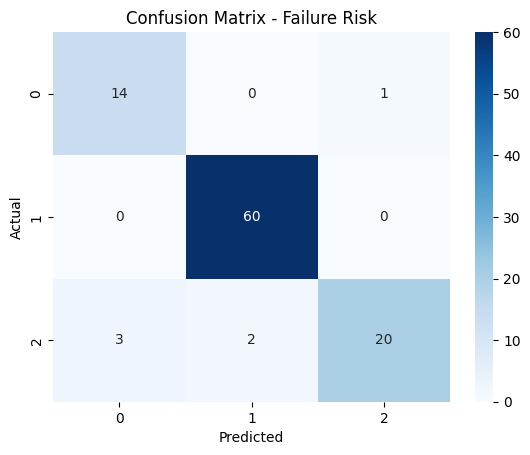

In [17]:
# For Failure Risk classification
print("Classification Report for Failure Risk:")
print(classification_report(Y_test_r, Y_pred_r))
sns.heatmap(confusion_matrix(Y_test_r, Y_pred_r), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Failure Risk")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# From the matrix:
1. **Class 0 (High Risk):**
   *   Correctly predicted: 14 out of 15
   *   Misclassified: 1 time

2. **Class 1 (Low Risk):**
   *   Correctly predicted: 60 out of 60
   *   Misclassified: 0 times

3. **Class 3 (Medium Risk):**
   *   Correctly predicted: 20 out of 25
   *   Misclassified as class 0: 3 times and as class 1: 2 times

# Insight:
The model achieves excellent accuracy (94%), especially in identifying Low Risk machines with perfect precision and recall. High Risk predictions are also strong, with only 1 misclassification. Medium Risk cases show some overlap with both Low and High, suggesting that borderline cases could benefit from clearer feature separation or more training examples.




Classification Report for Failure Type:
                                                                       precision    recall  f1-score   support

                                                       Acoustic Fault       0.67      1.00      0.80         2
                                      Acoustic Fault, Excess Downtime       0.00      0.00      0.00         1
                         Acoustic Fault, Excess Downtime, Overheating       0.00      0.00      0.00         2
Acoustic Fault, Excess Downtime, Overheating, Overload, RPM Overspeed       0.00      0.00      0.00         1
                                          Acoustic Fault, Overheating       0.75      1.00      0.86         3
                                Acoustic Fault, Overheating, Overload       1.00      1.00      1.00         2
                 Acoustic Fault, Overheating, Overload, RPM Overspeed       1.00      1.00      1.00         2
                           Acoustic Fault, Overheating, RPM Overspeed  

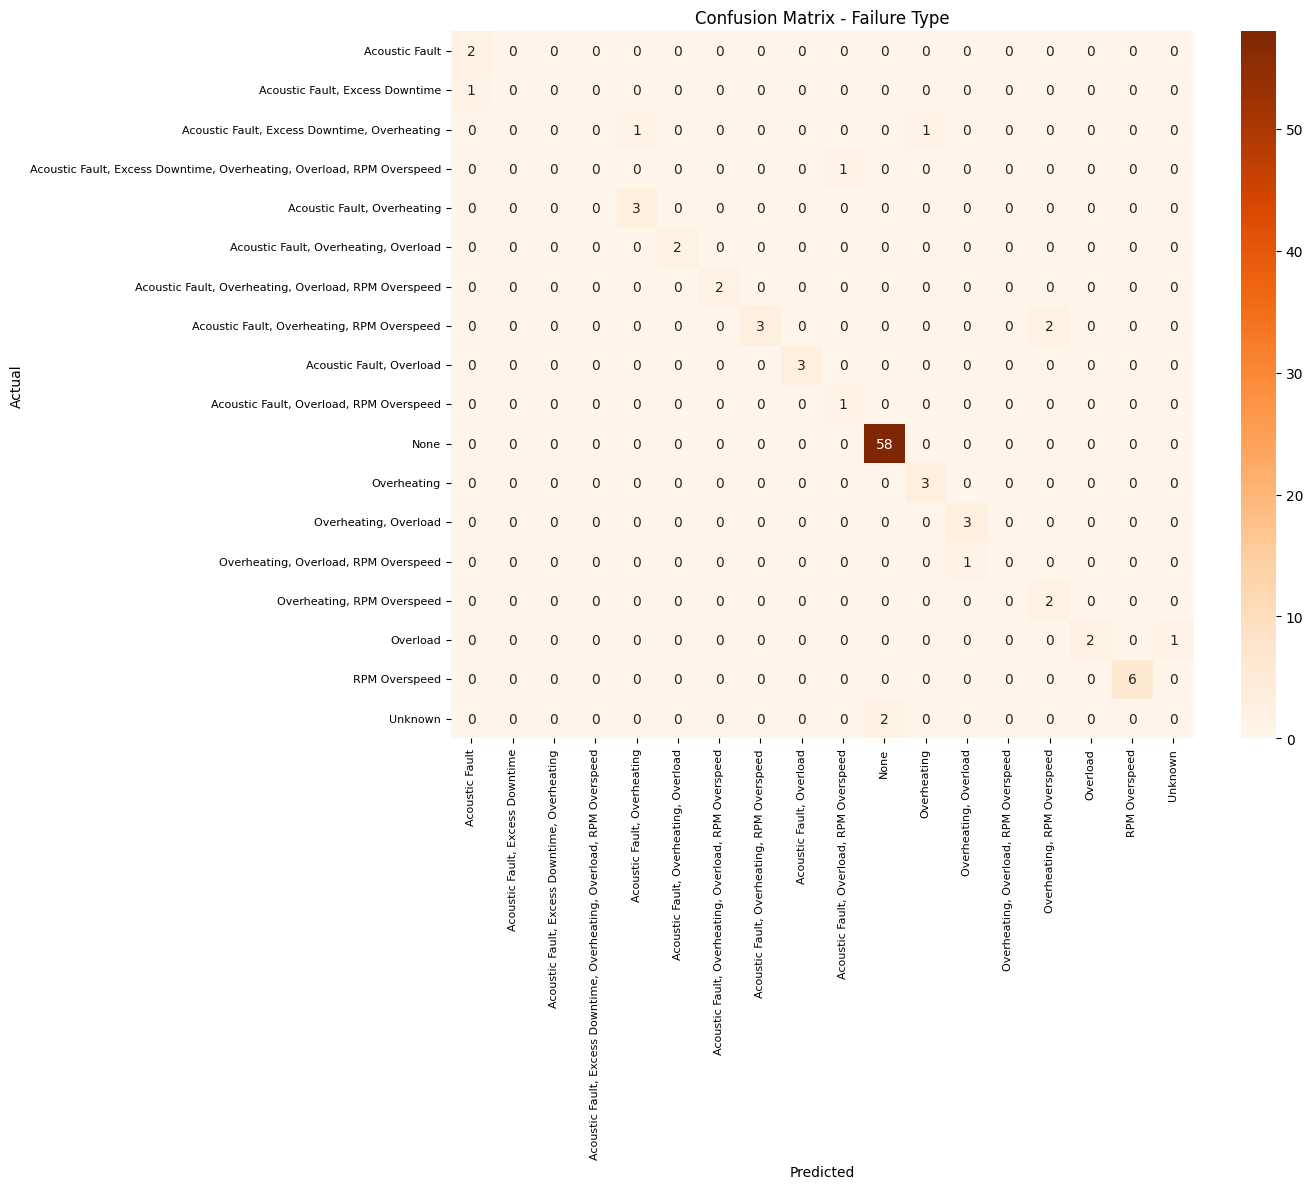

In [18]:
# For Failure Type Classification
df['failure_type'] = df['failure_type'].astype('category')
all_categories = df['failure_type'].cat.categories
labels_y = sorted(set(Y_test_y) | set(Y_pred_y))
target_names_y = sorted(set(Y_test_y) | set(Y_pred_y))

print("Classification Report for Failure Type:")
print(classification_report(Y_test_y, Y_pred_y, labels=labels_y, target_names=target_names_y, zero_division=0))
cm = confusion_matrix(Y_test_y, Y_pred_y, labels=labels_y)
plt.figure(figsize=(14, 12))
sns.heatmap(confusion_matrix(Y_test_y, Y_pred_y),
            annot=True,
            fmt='d',
            cmap='Oranges',
            xticklabels=target_names_y,
            yticklabels=target_names_y)

plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.title("Confusion Matrix - Failure Type")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()  # Ensures labels fit
plt.show()

# From the matrix:
1. **Class: "None"**
   *   Correctly predicted: 58 out of 58
   *   Misclassified: 0 times
   *   Perfect performance in this class.

2. **Class: "RPM Overspeed"**
   *   Correctly predicted: 6 out of 6
   *   Misclassified: 0 times
   *   Perfect precision and recall.

3. **Class: "Acoustic Fault"**
   *   Correctly predicted: 2 out of 2
   *   Misclassified: 0 times
   *   Model performs excellently on this class.

4. **Class: "Overload"**
   *   Correctly predicted: 2 out of 3
   *   Misclassified: 1 time
   *   Slight room for improvement.

5. **Class: "Vibration"**
   *   Not present as a standalone class in this confusion matrix/report.
   *   So its individual performance can't be directly evaluated.

6. **Class: "Overheating"**
   *   Correctly predicted: 3 out of 3
   *   Misclassified: 0 times
   *   High confidence in this fault type.

7. **Class: "Unknown"**
   *   Correctly predicted: 0 out of 2
   *   Misclassified as "None": 2 times
   *   Some confusion with non-failure scenarios.

8. **Compound Classes (e.g., "Overheating, RPM Overspeed", "Vibration, Overload", etc.)**
   *   Misclassified into related simpler classes (e.g., "Overheating", "RPM Overspeed").
   *   Frequently predicted as simpler single faults.

# Insight:
The model demonstrates strong reliability for well-represented, individual fault types such as "None", "Acoustic Fault", and "RPM Overspeed", all of which were predicted perfectly. However, it struggles with underrepresented, complex fault combinations and tends to collapse them into simpler categories. With an overall accuracy of 90% and strong performance on common faults, the model is highly useful for typical scenarios, but multi-fault generalization needs more data or tailored approaches.


RUL Regression Evaluation:
MSE: 239359.94
RMSE: 489.24425392640023
R² Score: 0.9140500237892185


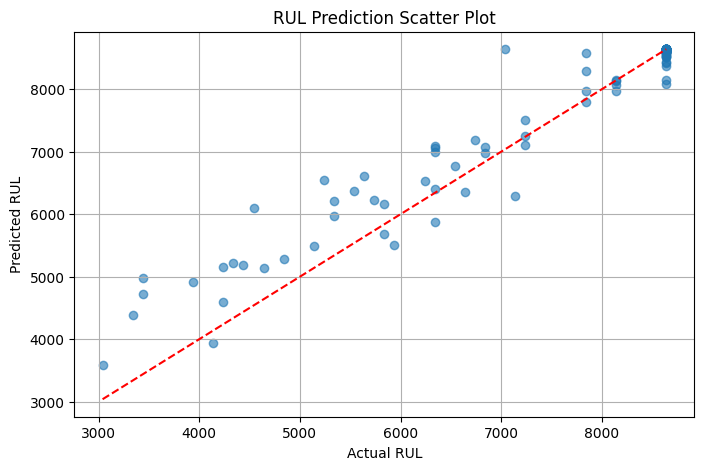

In [19]:
# For Remaining Useful Life (RUL) Regression
print("RUL Regression Evaluation:")
print("MSE:", mean_squared_error(Y_test_u, Y_pred_u))
print("RMSE:", np.sqrt(mean_squared_error(Y_test_u, Y_pred_u)))
print("R² Score:", r2_score(Y_test_u, Y_pred_u))

plt.figure(figsize=(8, 5))
plt.scatter(Y_test_u, Y_pred_u, alpha=0.6)
plt.plot([min(Y_test_u), max(Y_test_u)], [min(Y_test_u), max(Y_test_u)], 'r--')
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("RUL Prediction Scatter Plot")
plt.grid(True)
plt.show()

# From the Regression evaluation report:
1. R² Score: 0.914
   * The model explains 91.4% of the variance in actual RUL values — indicating an excellent fit and high predictive reliability.

2. RMSE: 489.24
   * On average, the predictions deviate from actual RUL values by around 489 units, which is relatively low considering the RUL range (3000-8500).

3. MSE: 239,359.94
   * This reflects squared error magnitude; although numerically large, it is acceptable given the high RUL values involved.

# Insight:
The scatter plot shows a strong alignment with the ideal diagonal, reflecting that the model's predictions closely follow actual RUL values. Most points lie near the trend line, with minimal under- or over-prediction and no major outliers. The model performs significantly better than before, especially in long-term RUL ranges, and is well-suited for predictive maintenance tasks requiring accurate life estimations.

# **8. For deployment in Streamlit**